# An introduction to Predictive Modeling in Python

This notebook walks through an example of using supervised learning on structured data.

Start by importing some basic libraries. ```%matplotlib inline``` will allow us to print some charts inside the notebook later using ```matplotlib.pyplot``` later. ```numpy``` is a library to manage large arrays. ```pandas``` is a library for data manipulation and analytics. These are the foundation for doing data preparation for AI/ML.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

#import warnings
#warnings.simplefilter('ignore', DeprecationWarning)

## Loading tabular data from the Titanic kaggle challenge in a pandas Data Frame

Let us have a look at the Titanic dataset from the Kaggle Getting Started challenge at:

https://www.kaggle.com/c/titanic-gettingStarted

We can load the CSV file as a pandas data frame in one line. First, find the Current Working Directory for the Notebook's python kernel and then fill in the path for the dataset that came with the cloned git repo.

In [2]:
%%sh
pwd

/home/u157922/git/Jupyter-Notebooks/machine_learning/tutorials/parallel_ml_tutorial/notebooks


In [3]:
#data = pd.read_csv('../datasets/titanic_train.csv')
data = pd.read_csv('/home/u157922/git/AIML-101/data/train.csv')

```pandas``` data frames have a HTML table representation in Jupyter Notebook.s Let's have a look at the first 6 rows:

In [4]:
data.head(6)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q


In [5]:
data.count()

PassengerId    891
Survived       891
Pclass         891
Name           891
Sex            891
Age            714
SibSp          891
Parch          891
Ticket         891
Fare           891
Cabin          204
Embarked       889
dtype: int64

The data frame has 891 rows. Some passengers have missing information though: in particular Age and Cabin info can be missing. The meaning of each the columns is explained on the challenge website:

https://www.kaggle.com/c/titanic-gettingStarted/data

A data frame can be converted into a numpy array by calling the `values` attribute:

In [6]:
data.values

array([[1, 0, 3, ..., 7.25, nan, 'S'],
       [2, 1, 1, ..., 71.2833, 'C85', 'C'],
       [3, 1, 3, ..., 7.925, nan, 'S'],
       ...,
       [889, 0, 3, ..., 23.45, nan, 'S'],
       [890, 1, 1, ..., 30.0, 'C148', 'C'],
       [891, 0, 3, ..., 7.75, nan, 'Q']], dtype=object)

However this cannot be directly fed to a scikit-learn model:


- the target variable (survival) is mixed with the input data

- some attribute such as unique ids have no predictive values for the task

- the values are heterogeneous (string labels for categories, integers and floating point numbers)

- some attribute values are missing (NaN: "not a number")

### Questions:

* Which fields do you think will be most predictive? (Pclass, Name, Sex, Age, SibSp, Parch, Ticket, Fare, Cabin, Embarked)

* How would you handle missing values in the data?

## Predicting survival

The goal of the Kaggle challenge is to predict whether a passenger has survived from others known attribute. Let us have a look at the `Survived` columns:

In [7]:
data.Survived.dtype

dtype('int64')

In [8]:
np.mean(data.Survived == 0)

0.6161616161616161

From this the subset of the full passengers list, about 2/3 perished in the event. So if we are to build a predictive model from this data, a baseline model to compare the performance to would be to always predict death. Such a constant model would reach around 62% predictive accuracy (which is higher than predicting at random):

pandas `Series` (columns) instances can be converted to regular 1D numpy arrays by using the `values` attribute:

In [9]:
target = data.Survived.values
type(target)

numpy.ndarray

In [10]:
target.dtype

dtype('int64')

The Survived field is technically a Boolean. We could have told pandas that when we imported the data by passing a Schema, but we can cast the array now as well:

In [11]:
data['Survived'] = data['Survived'].astype('bool')
target_bool = target.astype(dtype=bool)
print("numpy array datatype:", target_bool.dtype)
print("numpy array values:",target[:6])
print("pandas DataFrame field values:\n",data['Survived'].head(6))

numpy array datatype: bool
numpy array values: [0 1 1 1 0 0]
pandas DataFrame field values:
 0    False
1     True
2     True
3     True
4    False
5    False
Name: Survived, dtype: bool


## Training a predictive model on numerical features

`sklearn` works with homegeneous numerical feature descriptors passed as a numpy array. Therefore passing the raw data frame will not work out of the box.

Let us start simple and build a first model that only uses readily available numerical features as input, namely `data.Fare`, `data.Pclass` and `data.Age`.

In [12]:
numerical_features = data.get(['Fare', 'Pclass', 'Age'])
numerical_features.head(6)

,Fare,Pclass,Age
0,7.2500,3,22.0
1,71.2833,1,38.0
2,7.9250,3,26.0
3,53.1000,1,35.0
4,8.0500,3,35.0
5,8.4583,3,NaN


Unfortunately some passengers do not have age information:

In [13]:
numerical_features.count()

Fare      891
Pclass    891
Age       714
dtype: int64

Let's use pandas to get the median value for the data we do have and then the `fillna` method to input the median age for those passengers:

In [14]:
median_features = numerical_features.dropna().median()
median_features

Fare      15.7417
Pclass     2.0000
Age       28.0000
dtype: float64

In [15]:
imputed_features = numerical_features.fillna(median_features)
imputed_features.count()

Fare      891
Pclass    891
Age       891
dtype: int64

In [16]:
imputed_features.head(6)

,Fare,Pclass,Age
0,7.2500,3,22.0
1,71.2833,1,38.0
2,7.9250,3,26.0
3,53.1000,1,35.0
4,8.0500,3,35.0
5,8.4583,3,28.0


Now that the data frame is clean, we can convert it into an homogeneous numpy array of floating point values:

In [17]:
features_array = imputed_features.values
features_array

array([[ 7.25  ,  3.    , 22.    ],
       [71.2833,  1.    , 38.    ],
       [ 7.925 ,  3.    , 26.    ],
       ...,
       [23.45  ,  3.    , 28.    ],
       [30.    ,  1.    , 26.    ],
       [ 7.75  ,  3.    , 32.    ]])

Let's take the 80% of the data for training a first model and keep 20% for computing is generalization score:

In [18]:
from sklearn.model_selection import train_test_split

features_train, features_test, target_train, target_test = train_test_split(
    features_array, target_bool, test_size=0.20, random_state=20)

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [19]:
print("feature_train:".ljust(30), features_train.shape)
print("feature_test:".ljust(30), features_test.shape)
print("target_train:".ljust(30), target_train.shape)
print("target_test:".ljust(30), target_test.shape)

feature_train:                 (712, 3)
feature_test:                  (179, 3)
target_train:                  (712,)
target_test:                   (179,)


Let's start with a simple model from sklearn, `LogisticRegression`:

In [20]:
from sklearn.linear_model import LogisticRegression

logreg_initial = LogisticRegression()
logreg_initial.fit(features_train, target_train)

LogisticRegression()

The ```fit``` function trains the model using the features in our training set(```features_train```), and the expected prediction for each passenger (```target_train```). Now let's perform inference using using the records in our test set (```features_test```):

In [21]:
target_predicted = logreg_initial.predict(features_test)

Now we can compare our model's predictions with the actual data:

In [22]:
from sklearn.metrics import accuracy_score

accuracy_score(target_test, target_predicted)

0.7039106145251397

### Questions:

* How does this compare with our baseline prediction of 61.6%?

## Saving and Loading Models

In the previous section we trained('fit') a model and performed inference('predict') back to back. In many cases training takes a significant amount of time and then the model is saved and re-loaded for use later - potentially on different system(s).

Let's save our LinearRegression model:

In [23]:
import pickle

# save model for use later
with open('model.pkl','wb') as f:
    pickle.dump(logreg_initial,f)

Check and see that the model was written out to a file:

In [24]:
%%sh
ls -lh model.pkl

-rw------- 1 u157922 u157922 705 Dec 13 15:39 model.pkl


Now let's read the model back in and use it to perform the prediction again:

In [25]:
# read model back in
with open('model.pkl', 'rb') as f:
    logreg_reloaded = pickle.load(f)

target_repredicted = logreg_reloaded.predict(features_test)
accuracy_score(target_test, target_repredicted)

0.7039106145251397

Let's try a different mix of the data set by re-splitting our dataset with a different ```random_state```.

In [26]:
new_features_train, new_features_test, new_target_train, new_target_test = train_test_split(
    features_array, target_bool, test_size=0.20, random_state=10)

new_target_predicted = logreg_reloaded.predict(new_features_test)
accuracy_score(new_target_test, new_target_predicted)

0.776536312849162

### Questions:

* What are some reasons why the accuracy is different between the two sets of feature_test data?

## Model evaluation and interpretation

### Interpreting linear model weights

The `coef_` attribute of a fitted linear model such as `LogisticRegression` holds the weights of each features:

coef: [[ 0.00444186 -0.94109609 -0.03514215]]


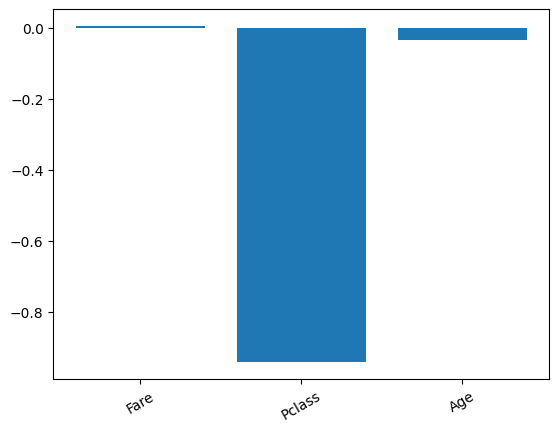

In [27]:
print("coef:", logreg_initial.coef_)

x = np.arange(len(numerical_features.columns.values))
plt.bar(numerical_features.columns.values, logreg_initial.coef_.ravel())
_ = plt.xticks(numerical_features.columns.values, rotation=30)

### Questions:

* What does the importance of these features mean for the passengers of the Titanic?

### Alternative evaluation metrics

Logistic Regression is a probabilistic models: instead of just predicting a binary outcome (survived or not) given the input features it can also estimates the posterior probability of the outcome given the input features using the `predict_proba` method:

In [28]:
target_predicted_proba = logreg_initial.predict_proba(features_test)
target_predicted_proba[:6]

array([[0.76652202, 0.23347798],
       [0.5791277 , 0.4208723 ],
       [0.44571467, 0.55428533],
       [0.72627743, 0.27372257],
       [0.50663936, 0.49336064],
       [0.4024492 , 0.5975508 ]])

By default the decision threshold is 0.5: if we vary the decision threshold from 0 to 1 we could generate a family of binary classifier models that address all the possible trade offs between false positive and false negative prediction errors.

We can summarize the performance of a binary classifier for all the possible thresholds by plotting the ROC curve and quantifying the Area under the ROC curve:

In [29]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

def plot_roc_curve(target_test, target_predicted_proba):
    fpr, tpr, thresholds = roc_curve(target_test, target_predicted_proba[:, 1])
    
    roc_auc = auc(fpr, tpr)
    # Plot ROC curve
    plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate or (1 - Specifity)')
    plt.ylabel('True Positive Rate or (Sensitivity)')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")

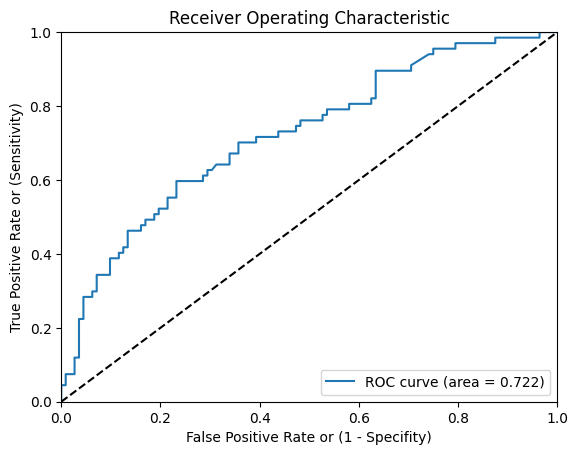

In [30]:
plot_roc_curve(target_test, target_predicted_proba)

Here the area under ROC curve is 0.722 which is very similar to the accuracy (0.732). The ROC-AUC score of a random model is expected to be 0.5 on average while the accuracy score of a random model depends on the class imbalance of the data. ROC-AUC can be seen as a way to callibrate the predictive accuracy of a model against class imbalance.

It is possible to see the details of the false positive and false negative errors by computing the confusion matrix:

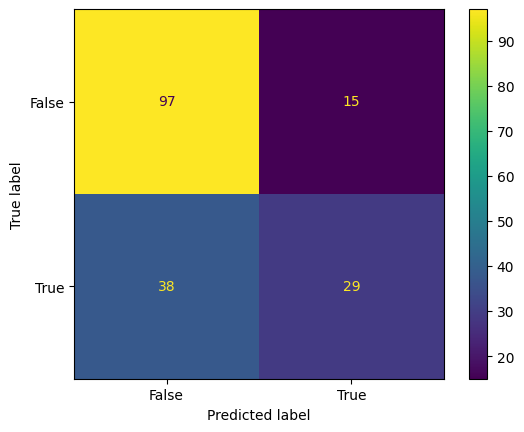

In [31]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(target_test, target_predicted, labels=logreg_initial.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=logreg_initial.classes_)
disp.plot()

Another way to quantify the quality of a binary classifier on imbalanced data is to compute the precision, recall and f1-score of a model (at the default fixed decision threshold of 0.5).

In [32]:
from sklearn.metrics import classification_report

print(classification_report(target_test, target_predicted,
                            target_names=['not survived', 'survived']))

              precision    recall  f1-score   support

not survived       0.72      0.87      0.79       112
    survived       0.66      0.43      0.52        67

    accuracy                           0.70       179
   macro avg       0.69      0.65      0.65       179
weighted avg       0.70      0.70      0.69       179



Precision is the measure of the number of True Positives relative to the total number of Positive outcomes predicted: TP / (TP + FP).

Recall is the measure of the number of True Positives relative to the number of ground truth Positives: TP / (TP + FN)

F1-Score balances the Precision and Recall scores: F1 = 2 * (Precision * Recall) / (Precision + Recall)

Support gives the number of how many of each kind of record were in our dataset.

### Cross-validation

We previously decided to randomly split the data to evaluate the model on 20% of held-out data. However the location randomness of the split might have a significant impact on the estimated accuracy:

In [33]:
features_train, features_test, target_train, target_test = train_test_split(
    features_array, target_bool, test_size=0.20, random_state=0)

logreg_initial.fit(features_train, target_train).score(features_test, target_test)

0.7318435754189944

In [34]:
features_train, features_test, target_train, target_test = train_test_split(
    features_array, target, test_size=0.20, random_state=1)

logreg_initial.fit(features_train, target_train).score(features_test, target_test)

0.6703910614525139

In [35]:
features_train, features_test, target_train, target_test = train_test_split(
    features_array, target, test_size=0.20, random_state=2)

logreg_initial.fit(features_train, target_train).score(features_test, target_test)

0.6927374301675978

So instead of using a single train / test split, we can use a group of them and compute the min, max and mean scores as an estimation of the real test score while not underestimating the variability:

In [36]:
%%time

from sklearn.model_selection import cross_val_score

scores = cross_val_score(logreg_initial, features_array, target_bool, cv=3)
scores

CPU times: user 152 ms, sys: 21.4 ms, total: 173 ms
Wall time: 18 ms


array([0.65319865, 0.71380471, 0.71717172])

In [37]:
scores.min(), scores.mean(), scores.max()

(0.6531986531986532, 0.6947250280583613, 0.7171717171717171)

`cross_val_score` reports accuracy by default but it can also be used to report other performance metrics such as ROC-AUC or f1-score:

In [38]:
%%time

scores = cross_val_score(logreg_initial, features_array, target_bool, cv=3,
                         scoring='roc_auc')
scores.min(), scores.mean(), scores.max()

CPU times: user 537 ms, sys: 43.7 ms, total: 581 ms
Wall time: 159 ms


(0.6497219825520084, 0.7186271690154347, 0.7846563129134311)

**Exercise**:

- Compute cross-validated scores for other classification metrics ('precision', 'recall', 'f1', 'accuracy'...).

- Change the number of cross-validation folds between 3 and 10: what is the impact on the mean score? on the processing time?

Hints:

The list of classification metrics is available in the online documentation:

  http://scikit-learn.org/stable/modules/model_evaluation.html#common-cases-predefined-values

## More feature engineering and richer models

Let us now try to build richer models by including more features as potential predictors for our model.

Categorical variables such as `data.Embarked` or `data.Sex` can be converted as boolean indicators features also known as dummy variables or one-hot-encoded features:

In [39]:
pd.get_dummies(data.Sex, prefix='Sex').head(5)

,Sex_female,Sex_male
0,0,1
1,1,0
2,1,0
3,1,0
4,0,1


In [40]:
pd.get_dummies(data.Embarked, prefix='Embarked').head(5)

,Embarked_C,Embarked_Q,Embarked_S
0,0,0,1
1,1,0,0
2,0,0,1
3,0,0,1
4,0,0,1


We can combine those new numerical features with the previous features using `pandas.concat` along `axis=1`:

In [41]:
rich_features = pd.concat([data.get(['Fare', 'Age','Pclass']),
                           pd.get_dummies(data.Sex, prefix='Sex'),
                           pd.get_dummies(data.Embarked, prefix='Embarked')],
                          axis=1)
rich_features.head(6)

,Fare,Age,Pclass,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,7.2500,22.0,3,0,1,0,0,1
1,71.2833,38.0,1,1,0,1,0,0
2,7.9250,26.0,3,1,0,0,0,1
3,53.1000,35.0,1,1,0,0,0,1
4,8.0500,35.0,3,0,1,0,0,1
5,8.4583,NaN,3,0,1,0,1,0


In this case, by construction the new `Sex_male` feature is redundant with `Sex_female`. Let's drop it:

In [42]:
rich_features_no_male = rich_features.drop(columns='Sex_male', axis=1)
rich_features_no_male.head(6)

,Fare,Age,Pclass,Sex_female,Embarked_C,Embarked_Q,Embarked_S
0,7.2500,22.0,3,0,0,0,1
1,71.2833,38.0,1,1,1,0,0
2,7.9250,26.0,3,1,0,0,1
3,53.1000,35.0,1,1,0,0,1
4,8.0500,35.0,3,0,0,0,1
5,8.4583,NaN,3,0,0,1,0


Let us not forget to imput the median age for passengers without age information:

In [43]:
rich_features_final = rich_features_no_male.fillna(rich_features_no_male.dropna().median())
rich_features_final.head(6)

,Fare,Age,Pclass,Sex_female,Embarked_C,Embarked_Q,Embarked_S
0,7.2500,22.0,3,0,0,0,1
1,71.2833,38.0,1,1,1,0,0
2,7.9250,26.0,3,1,0,0,1
3,53.1000,35.0,1,1,0,0,1
4,8.0500,35.0,3,0,0,0,1
5,8.4583,28.0,3,0,0,1,0


We can finally cross-validate a logistic regression model on this new data and observe that the mean score has significantly increased:

In [44]:
%%time

logreg = LogisticRegression(max_iter=225)
scores = cross_val_score(logreg, rich_features_final, target_bool, cv=5, scoring='accuracy')
print(scores.min(), scores.mean(), scores.max())

0.7696629213483146 0.7822672776348002 0.7921348314606742
CPU times: user 664 ms, sys: 477 ms, total: 1.14 s
Wall time: 147 ms


Let's plot the weights for the features of this newly fitted logistic regression model:

coef: [[ 2.74525689e-05 -3.27741766e-02 -1.13043025e+00  2.48946113e+00
   9.38649609e-02  7.72708286e-02 -4.04197620e-01]]


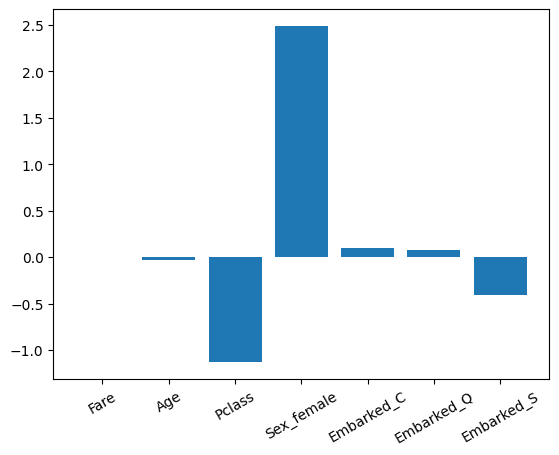

In [45]:
logreg.fit(rich_features_final, target_bool)

print("coef:", logreg.coef_)

x = np.arange(len(numerical_features.columns.values))
plt.bar(rich_features_final.columns.values, logreg.coef_.ravel())
_ = plt.xticks(rich_features_final.columns.values, rotation=30)

### Questions:

* How do you interpret the importance of the new features?

### Training Non-linear models: ensembles of randomized trees

`sklearn` also implements non linear models that are known to perform very well for data-science projects where datasets don't have a huge number of features (e.g. less than 5000). A full list of `sklearn` supervised learning models can be found here: https://scikit-learn.org/stable/supervised_learning.html

Let us have a look at Random Forests and Gradient Boosted Trees:

In [46]:
%%time

from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100)
scores = cross_val_score(rf, rich_features_final, target_bool, cv=5, n_jobs=4,
                         scoring='accuracy')
print(scores.min(), scores.mean(), scores.max())

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


0.776536312849162 0.8081162513338773 0.8426966292134831
CPU times: user 39.3 ms, sys: 50.8 ms, total: 90.2 ms
Wall time: 2.47 s


In [47]:
%%time

from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1,
                                subsample=.8, max_features=.5)
gb_scores = cross_val_score(gb, rich_features_final, target_bool, cv=5, n_jobs=4,
                         scoring='accuracy')
print(gb_scores.min(), gb_scores.mean(), gb_scores.max())

0.8089887640449438 0.8327851358985624 0.848314606741573
CPU times: user 17.7 ms, sys: 500 µs, total: 18.2 ms
Wall time: 233 ms


Both models seem to do slightly better than the logistic regression model on this data.

**Exercise**:

- Change the value of the learning_rate and other `GradientBoostingClassifier` parameter, can you get a better mean score?

- Would treating the `PClass` variable as categorical improve the models performance?

- Find out which predictor variables (features) are the most informative for those models.

Hints:

Fitted ensembles of trees have `feature_importance_` attribute that can be used similarly to the `coef_` attribute of linear models.

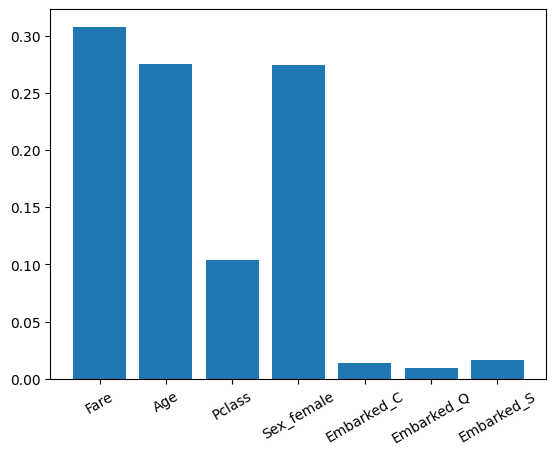

In [48]:
rf.fit(rich_features_final, target)
rf.feature_importances_
rf_feature_importances = pd.DataFrame(rf.feature_importances_, index=rich_features_final.columns,  columns=['importance']).sort_values('importance', ascending=False)

x = np.arange(len(rich_features_final.columns))
plt.bar(x, rf.feature_importances_.ravel())
_ = plt.xticks(x, rich_features_final.columns, rotation=30)

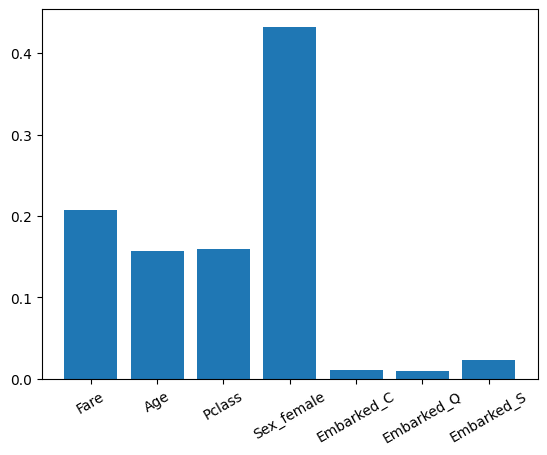

In [49]:
gb.fit(rich_features_final, target)
gb.feature_importances_
gb_feature_importances = pd.DataFrame(gb.feature_importances_, index=rich_features_final.columns,  columns=['importance']).sort_values('importance', ascending=False)

x = np.arange(len(rich_features_final.columns))
plt.bar(x, gb.feature_importances_.ravel())
_ = plt.xticks(x, rich_features_final.columns, rotation=30)

## Automated parameter tuning

Instead of changing the value of the learning rate manually and re-running the cross-validation, we can find the best values for the parameters automatically (assuming we are willing to wait):

In [50]:
%%time

from sklearn.model_selection import GridSearchCV

gb = GradientBoostingClassifier(n_estimators=100, subsample=.8)

params = {
    'learning_rate': [0.05, 0.1, 0.5],
    'max_features': [0.5, 1],
    'max_depth': [3, 4, 5],
}
gs = GridSearchCV(gb, params, cv=5, scoring='roc_auc', n_jobs=4)
gs.fit(rich_features_final, target)

CPU times: user 244 ms, sys: 13.8 ms, total: 258 ms
Wall time: 2.24 s


GridSearchCV(cv=5, estimator=GradientBoostingClassifier(subsample=0.8),
             n_jobs=4,
             param_grid={'learning_rate': [0.05, 0.1, 0.5],
                         'max_depth': [3, 4, 5], 'max_features': [0.5, 1]},
             scoring='roc_auc')

Let us sort the models by mean validation score:

In [51]:
gs.cv_results_['mean_test_score']

array([0.86951897, 0.860402  , 0.86826645, 0.86751655, 0.87313667,
       0.87498987, 0.87247144, 0.86330012, 0.87217669, 0.86907187,
       0.87200666, 0.86556751, 0.86581373, 0.86180677, 0.86906533,
       0.86556973, 0.83399859, 0.85450717])

In [52]:
gs.best_score_

0.874989871497063

In [53]:
gs.best_params_

{'learning_rate': 0.05, 'max_depth': 5, 'max_features': 1}

We should note that the mean scores are very close to one another and almost always within one standard deviation of one another. This means that all those parameters are quite reasonable.

## Avoiding data snooping with pipelines

When doing imputation in pandas, prior to computing the train test split we use data from the test to improve the accuracy of the median value that we impute on the training set. This is actually cheating. To avoid this we should compute the median of the features on the training fold and use that median value to do the imputation both on the training and validation fold for a given CV split.

To do this we can prepare the features as previously but without the imputation: we just replace missing values by the -1 marker value:

In [54]:
features = pd.concat([data.get(['Fare', 'Age', 'Pclass']),
                      pd.get_dummies(data.Sex, prefix='Sex'),
                      pd.get_dummies(data.Embarked, prefix='Embarked')],
                     axis=1)
features = features.drop(columns='Sex_male', axis=1)

# Because of the following bug we cannot use NaN as the missing
# value marker, use a negative value as marker instead:
# https://github.com/scikit-learn/scikit-learn/issues/3044
features = features.fillna(-1)
features.head(6)

,Fare,Age,Pclass,Sex_female,Embarked_C,Embarked_Q,Embarked_S
0,7.2500,22.0,3,0,0,0,1
1,71.2833,38.0,1,1,1,0,0
2,7.9250,26.0,3,1,0,0,1
3,53.1000,35.0,1,1,0,0,1
4,8.0500,35.0,3,0,0,0,1
5,8.4583,-1.0,3,0,0,1,0


We can now use the `Imputer` transformer of scikit-learn to find the median value on the training set and apply it on missing values of both the training set and the test set.

In [55]:
from sklearn.model_selection import train_test_split

X_train, X_test = train_test_split(features.values, random_state=1)

In [56]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='median', missing_values=-1)

imputer.fit(X_train)

SimpleImputer(missing_values=-1, strategy='median')

The median age computed on the training set is stored in the `statistics_` attribute.

In [57]:
print("Median age of full set:".ljust(30), median_features['Age'])
print("Median age of training set:".ljust(30), imputer.statistics_[1])

Median age of full set:        28.0
Median age of training set:    29.0


Imputation can now happen by calling  the transform method:

In [58]:
X_train_imputed = imputer.transform(X_train)
X_test_imputed = imputer.transform(X_test)

In [59]:
np.any(X_train == -1)

True

In [60]:
np.any(X_train_imputed == -1)

False

In [61]:
np.any(X_test == -1)

True

In [62]:
np.any(X_test_imputed == -1)

False

We can now use a pipeline that wraps an imputer transformer and the classifier itself:

In [63]:
from sklearn.pipeline import Pipeline

imputer = SimpleImputer(strategy='median', missing_values=-1)

classifier = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1,
                                        subsample=.8, max_features=.5)

pipeline = Pipeline([
    ('imp', imputer),
    ('clf', classifier),
])

scores = cross_val_score(pipeline, features.values, target, cv=5, n_jobs=4,
                         scoring='accuracy', )
print("Scores with Snooping:".ljust(25), gb_scores.min(), gb_scores.mean(), gb_scores.max())
print("Scores without Snooping:".ljust(25), scores.min(), scores.mean(), scores.max())

Scores with Snooping:     0.8089887640449438 0.8327851358985624 0.848314606741573
Scores without Snooping:  0.7865168539325843 0.8170861841692298 0.848314606741573


The mean cross-validation is slightly lower than when we used the imputation on the whole data as we did earlier although not by much. This means that in this case the data-snooping was not really helping the model cheat by much.

Let us re-run the grid search, this time on the pipeline. Note that thanks to the pipeline structure we can optimize the interaction of the imputation method with the parameters of the downstream classifier without cheating:

In [64]:
%%time

params = {
    'imp__strategy': ['mean', 'median'],
    'clf__max_features': [0.5, 1],
    'clf__max_depth': [3, 4, 5],
}
gs = GridSearchCV(pipeline, params, cv=5, scoring='roc_auc', n_jobs=4)
gs.fit(features, target)

CPU times: user 180 ms, sys: 10.6 ms, total: 191 ms
Wall time: 1.5 s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('imp',
                                        SimpleImputer(missing_values=-1,
                                                      strategy='median')),
                                       ('clf',
                                        GradientBoostingClassifier(max_features=0.5,
                                                                   subsample=0.8))]),
             n_jobs=4,
             param_grid={'clf__max_depth': [3, 4, 5],
                         'clf__max_features': [0.5, 1],
                         'imp__strategy': ['mean', 'median']},
             scoring='roc_auc')

In [65]:
gs.cv_results_['mean_test_score']

array([0.87291195, 0.87393483, 0.86657273, 0.86448097, 0.87221031,
       0.8734541 , 0.86899083, 0.87274055, 0.87331783, 0.87163794,
       0.86920824, 0.86639753])

In [66]:
gs.best_score_

0.8739348345132736

In [67]:
gs.best_params_

{'clf__max_depth': 3, 'clf__max_features': 0.5, 'imp__strategy': 'median'}

From this search we can conclude the best imputation strategy and tuning parameters when training a GBRT model on this data given the parameter search space we defined.

## Credits

Many thanks to:

- Adam Walz for providing the original version of this notebook https://github.com/adamwalz/Jupyter-Notebooks

Adam thanks:

- Kaggle for setting up the Titanic challenge.

- This blog post by Philippe Adjiman for inspiration:

http://www.philippeadjiman.com/blog/2013/09/12/a-data-science-exploration-from-the-titanic-in-r/

In [68]:
%%time

import autosklearn
import autosklearn.classification

#define the model
automl = autosklearn.classification.AutoSklearnClassifier(time_left_for_this_task=1200, n_jobs=4)

#train the model
automl.fit(rich_features_final, target_bool)
#y_pred=automl.predict_proba(X_val)

print(automl.sprint_statistics())

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


[ERROR] [2022-12-13 15:40:01,516:Client-AutoML(1):71d28982-7b3f-11ed-b700-91a3849e8238] (' Dummy prediction failed with run state StatusType.CRASHED and additional output: {\'traceback\': \'Traceback (most recent call last):\\n  File "/home/u157922/.local/lib/python3.9/site-packages/autosklearn/evaluation/__init__.py", line 397, in run\\n    obj(**obj_kwargs)\\n  File "/home/u157922/.local/lib/python3.9/site-packages/pynisher/limit_function_call.py", line 302, in __call__\\n    tmp_dir.cleanup()\\n  File "/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/tempfile.py", line 834, in cleanup\\n    self._rmtree(self.name)\\n  File "/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/tempfile.py", line 816, in _rmtree\\n    _shutil.rmtree(name, onerror=onerror)\\n  File "/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/shutil.py", line 740, in rmtree\\n    onerror(os.rmdir, path, sys.exc_info())\\n  File "/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/shutil.py", l

ValueError: (' Dummy prediction failed with run state StatusType.CRASHED and additional output: {\'traceback\': \'Traceback (most recent call last):\\n  File "/home/u157922/.local/lib/python3.9/site-packages/autosklearn/evaluation/__init__.py", line 397, in run\\n    obj(**obj_kwargs)\\n  File "/home/u157922/.local/lib/python3.9/site-packages/pynisher/limit_function_call.py", line 302, in __call__\\n    tmp_dir.cleanup()\\n  File "/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/tempfile.py", line 834, in cleanup\\n    self._rmtree(self.name)\\n  File "/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/tempfile.py", line 816, in _rmtree\\n    _shutil.rmtree(name, onerror=onerror)\\n  File "/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/shutil.py", line 740, in rmtree\\n    onerror(os.rmdir, path, sys.exc_info())\\n  File "/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/shutil.py", line 738, in rmtree\\n    os.rmdir(path)\\nOSError: [Errno 39] Directory not empty: \\\'/home/u157922/tmp/tmpuu0ggm3a\\\'\\n\', \'error\': "OSError(39, \'Directory not empty\')"}.',)

In [69]:
import PipelineProfiler
# automl is an object Which has already been created.
profiler_data= PipelineProfiler.import_autosklearn(automl)
PipelineProfiler.plot_pipeline_matrix(profiler_data)

AttributeError: 'AutoMLClassifier' object has no attribute 'runhistory_'